In [54]:
import random
import time
import os

from tqdm.notebook import tqdm

import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython import display

from torchvision.transforms import transforms
import torch.utils.data
from torchsummary import summary

import matplotlib.pyplot as plt
import itertools

from pytorchCycleGANandpix2pix.models import networks as offnets
from pytorchCycleGANandpix2pix.models import cycle_gan_model as cg
from pytorchCycleGANandpix2pix.util.image_pool import ImagePool
from pytorchCycleGANandpix2pix.util.util import tensor2im

import cyclegan_models

In [53]:
def revert_normalisation(tensor):
    return (tensor.permute(1, 2, 0) + 1) / 2

def revert_normalisation_batch(tensors):
    return (tensors.permute(0, 2, 3, 1) + 1) / 2

In [3]:
device = "cuda"

In [4]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler

import torchsummary


###############################################################################
# Helper Functions
###############################################################################


class Identity(nn.Module):
    def forward(self, x):
        return x


def get_norm_layer(norm_type='instance'):
    """Return a normalization layer

    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none

    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x):
            return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler

    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine

    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt.lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)


##############################################################################
# Classes
##############################################################################
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028

    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( ||gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss

    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


class PixelDiscriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)

In [60]:
model = offnets.define_G(input_nc=3, output_nc=3, ngf=64, netG="resnet_9blocks", norm="instance", use_dropout=False, init_gain=0.02, gpu_ids=[0])
#offnets.ResnetGenerator(3, 3, 64, norm_layer=get_norm_layer("instance"), use_dropout=False, n_blocks=9)

from collections import OrderedDict
model_dict = torch.load("./pytorchCycleGANandpix2pix/scripts/checkpoints/horse2zebra_pretrained/horse2zebra.pth")
new_dict = OrderedDict()
for k, v in model_dict.items():
    # load_state_dict expects keys with prefix 'module.'
    new_dict["module." + k] = v

own = model.state_dict()
for name, param in new_dict.items():
    if name not in own:
        continue
    model.state_dict()[name].copy_(param)



# "./pytorchCycleGANandpix2pix/checkpoints/off_cyc_494/200_net_G_A.pth"
model.to(device)
model.eval()

initialize network with normal


DataParallel(
  (module): ResnetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
      (10): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (3): ReLU(in

In [61]:
dist_test_image_loc = "./selected_data/experiment_stratified_selection_1678204517.945494_cyclegan_off/testB/half_body_0.jpg"
non_dist_test_image_loc = "./examples/non_dist_horse.jpg"

In [62]:
dist_test_image = cv2.cvtColor(cv2.imread(dist_test_image_loc), cv2.COLOR_BGR2RGB)
non_dist_test_image = cv2.cvtColor(cv2.imread(non_dist_test_image_loc), cv2.COLOR_BGR2RGB)

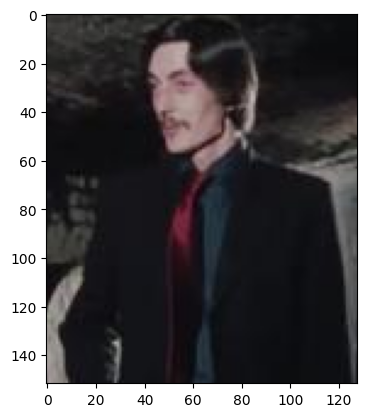

In [63]:
plt.imshow(dist_test_image)

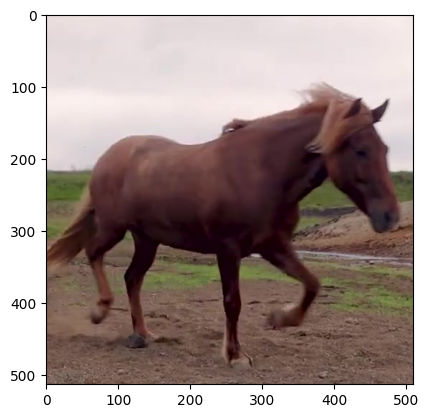

In [64]:
plt.imshow(non_dist_test_image)

In [65]:
preprocess_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [66]:
def revert_normalisation(tensor):
    return (tensor.permute(1, 2, 0) + 1) / 2

In [67]:
dist_test_tensor = preprocess_transform(dist_test_image).unsqueeze(0).to(device)
non_dist_test_tensor = preprocess_transform(non_dist_test_image).unsqueeze(0).to(device)

In [68]:
with torch.no_grad():
    dist_transferred = model(dist_test_tensor)
    non_dist_transferred = model(non_dist_test_tensor)

In [69]:
dist_transferred_img = revert_normalisation(dist_transferred.squeeze().cpu())
non_dist_transferred_img = revert_normalisation(non_dist_transferred.squeeze().cpu())

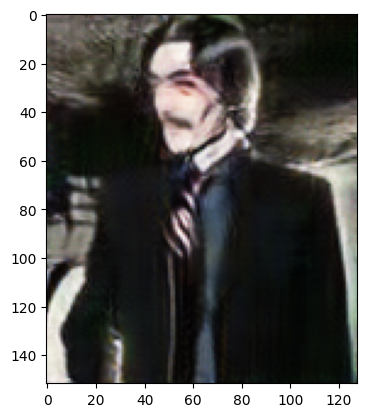

In [70]:
plt.imshow(dist_transferred_img)

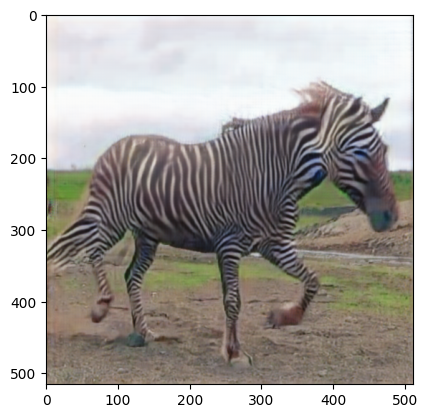

In [71]:
plt.imshow(non_dist_transferred_img)

In [72]:
def transfer_style_to_batch(cv2_images):
    imgs = [preprocess_transform(img) for img in cv2_images]
    imgs = torch.stack(imgs).to(device)
    
    with torch.no_grad():
        imgs_transferred = model(imgs)
    
    imgs_transferred = [revert_normalisation(img_t.cpu()) for img_t in imgs_transferred]
    return imgs_transferred

In [73]:
frame_locs = [
    "./frames/Test/Test_Test Movie_00056.jpg",
    "./frames/Test/Test_Test Movie_00199.jpg"
]

In [74]:
loaded_frames = [cv2.cvtColor(cv2.imread(frame_loc), cv2.COLOR_BGR2RGB) for frame_loc in frame_locs]

In [75]:
transferred_frames = transfer_style_to_batch(loaded_frames)

In [76]:
for i, frame in enumerate(transferred_frames):
    cv2.imwrite(f"./examples/off_cyc_494_000{i}_t.jpg", cv2.cvtColor(frame.numpy() * 255, cv2.COLOR_RGB2BGR))

In [78]:
video_in_loc = "./examples/horse_vid.mp4"
video_out_loc = "./examples/transferred_horse_vid_real.mp4"
batch_size = 4

In [79]:
video_in = cv2.VideoCapture(video_in_loc)

In [80]:
def process_video(video, save_loc):
    # Try to delete the existing saved file
    try:
        os.remove(save_loc)
    except OSError:
        pass 
    
    fps = int(video.get(cv2.CAP_PROP_FPS))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    success, frame = video.read()
    height, width, _ = frame.shape
    
    frame_buffer = []
    video_out = cv2.VideoWriter(save_loc, -1, fps, (width, height))
    
    with tqdm(total=total_frames) as progress:
        while success:
            frame_buffer.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if len(frame_buffer) == batch_size:
                transferred_frames = transfer_style_to_batch(frame_buffer)

                for out_frame in transferred_frames:
                    coloured_out_frame = cv2.cvtColor((out_frame.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                    video_out.write(coloured_out_frame)

                frame_buffer = []

            success, frame = video.read()
            progress.update(1)
    
    if len(frame_buffer) != 0:
        # Process any additional final frames that don't make a full batch
        transferred_frames = transfer_style_to_batch(frame_buffer)

        for out_frame in transferred_frames:
            coloured_out_frame = cv2.cvtColor((out_frame.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            video_out.write(coloured_out_frame)
    
    video_out.release()

In [81]:
process_video(video_in, video_out_loc)

  0%|          | 0/2245 [00:00<?, ?it/s]